In [2]:
# add to kfkd.py
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import numpy as np
import theano.tensor as T
from nolearn.lasagne import BatchIterator
from theano.sandbox.neighbours import neibs2images
from lasagne.objectives import squared_error as mse

### this is really dumb, current nolearn doesnt play well with lasagne, 
### so had to manually copy the file I wanted to this folder
from shape import ReshapeLayer

from lasagne.nonlinearities import tanh
import pickle
import sys
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import precision_score
import os
import urllib
import gzip
import cPickle
from IPython.display import Image as IPImage
from PIL import Image

Using gpu device 0: GeForce GTX 870M (CNMeM is disabled)


In [3]:
class Unpool2DLayer(layers.Layer):
    """
    This layer performs unpooling over the last two dimensions
    of a 4D tensor.
    """
    def __init__(self, incoming, ds, **kwargs):
        
        super(Unpool2DLayer, self).__init__(incoming, **kwargs)

        if (isinstance(ds, int)):
            raise ValueError('ds must have len == 2')
        else:
            ds = tuple(ds)
            if len(ds) != 2:
                raise ValueError('ds must have len == 2')
            if ds[0] != ds[1]:
                raise ValueError('ds should be symmetric (I am lazy)')
            self.ds = ds

    def get_output_shape_for(self, input_shape):
        output_shape = list(input_shape)

        output_shape[2] = input_shape[2] * self.ds[0]
        output_shape[3] = input_shape[3] * self.ds[1]

        return tuple(output_shape)

    def get_output_for(self, input, **kwargs):
        ds = self.ds
        input_shape = input.shape
        output_shape = self.get_output_shape_for(input_shape)
        return input.repeat(2, axis = 2).repeat(2, axis = 3)

In [4]:
### when we load the batches to input to the neural network, we randomly / flip rotate the images, to artificially
### increase the size of the training set

class FlipBatchIterator(BatchIterator):

    def transform(self, X1, X2):
        X1b, X2b = super(FlipBatchIterator, self).transform(X1, X2)
        X2b = X2b.reshape(X1b.shape)

        bs = X1b.shape[0]
        h_indices = np.random.choice(bs, bs / 2, replace=False) # horizontal flip
        v_indices = np.random.choice(bs, bs / 2, replace=False) # vertical flip
        
        ###  uncomment these lines if you want to include rotations (images must be square)  ###
        #r_indices = np.random.choice(bs, bs / 2, replace=False) # 90 degree rotation
        for X in (X1b, X2b):
            X[h_indices] = X[h_indices, :, :, ::-1]
            X[v_indices] = X[v_indices, :, ::-1, :]
            #X[r_indices] = np.swapaxes(X[r_indices, :, :, :], 2, 3)
        shape = X2b.shape
        X2b = X2b.reshape((shape[0], -1))

        return X1b, X2b

In [5]:
fname = 'mnist/mnist.pkl.gz'
if not os.path.isfile(fname):
    testfile = urllib.URLopener()
    testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
X, y = train_set
X = np.rint(X * 256).astype(np.int).reshape((-1, 1, 28,28)) # convert to (0,255) int range (we'll do our own scaling)
mu, sigma = np.mean(X.flatten()), np.std(X.flatten())

In [6]:
X_train = X.astype(np.float64)
X_train = (X_train - mu) / sigma
X_train = X_train.astype(np.float32)

# we need our target to be 1 dimensional
X_out = X_train.reshape((X_train.shape[0], -1))

In [7]:
conv_filters = 32
deconv_filters = 32
filter_sizes = 7
epochs = 20
encode_size = 40
ae = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv', layers.Conv2DLayer),
        ('pool', layers.MaxPool2DLayer),
        ('flatten', ReshapeLayer), # output_dense
        ('encode_layer', layers.DenseLayer),
        ('hidden', layers.DenseLayer), # output_dense
        ('unflatten', ReshapeLayer),
        ('unpool', Unpool2DLayer),
        ('deconv', layers.Conv2DLayer),
        ('output_layer', ReshapeLayer),
        ],
    input_shape=(None, 1, 28, 28),
    conv_num_filters=conv_filters, conv_filter_size = (filter_sizes, filter_sizes), 
    #conv_pad="same",
    conv_nonlinearity=None,
    pool_pool_size=(2, 2),
    flatten_shape=(([0], -1)), # not sure if necessary?
    encode_layer_num_units = encode_size,
    hidden_num_units= deconv_filters * (28 + filter_sizes - 1) ** 2 / 4,
    unflatten_shape=(([0], deconv_filters, (28 + filter_sizes - 1) / 2, (28 + filter_sizes - 1) / 2 )),
    unpool_ds=(2, 2),
    deconv_num_filters=1, deconv_filter_size = (filter_sizes, filter_sizes), 
    #deconv_pad="same",
    deconv_nonlinearity=None,
    output_layer_shape = (([0], -1)),
    update_learning_rate = 0.01,
    update_momentum = 0.975,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    regression=True,
    max_epochs= epochs,
    verbose=1,
    )
ae.fit(X_train, X_out)
print 
###  expect training / val error of about 0.087 with these parameters
###  if your GPU not fast enough, reduce the number of filters in the conv/deconv step

# Neural Network with 537257 learnable parameters

## Layer information

  #  name          size
---  ------------  --------
  0  input         1x28x28
  1  conv          32x22x22
  2  pool          32x11x11
  3  flatten       3872
  4  encode_layer  40
  5  hidden        9248
  6  unflatten     32x17x17
  7  unpool        32x34x34
  8  deconv        1x28x28
  9  output_layer  784

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.42700       0.20972      2.03602  54.44s
      2       0.17209       0.14542      1.18338  54.48s
      3       0.13335       0.12315      1.08288  54.33s
      4       0.11775       0.11157      1.05535  54.34s
      5       0.10948       0.10576      1.03519  54.33s
      6       0.10477       0.10143      1.03287  54.35s
      7       0.10105       0.09870      1.02378  54.37s
      8       0.09829       0.09669      1.01661  54.43s
      9       0.09602       0.09425      1.01871

In [53]:
import pickle
import sys
sys.setrecursionlimit(10000)

pickle.dump(ae, open('mnist/conv_ae.pkl','w'))
#ae = pickle.load(open('mnist/conv_ae.pkl','r'))
ae.save_params_to('mnist/conv_ae.np')

In [11]:
X_train_pred = ae.predict(X_train).reshape(-1, 28, 28) * sigma + mu
X_pred = np.rint(X_train_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print X_pred.shape , X.shape

(50000, 28, 28) (50000, 1, 28, 28)


210


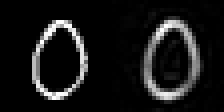

In [24]:
###  show random inputs / outputs side by side

def get_picture_array(X, index):
    array = X[index].reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(4, axis = 0).repeat(4, axis = 1).astype(np.uint8())

def get_random_images():
    index = np.random.randint(5000)
    print index
    original_image = Image.fromarray(get_picture_array(X, index))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred, index))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")    
    
get_random_images()
IPImage('data/test.png')

In [31]:
## we find the encode layer from our ae, and use it to define an encoding function

encode_layer_index = map(lambda pair : pair[0], ae.layers).index('encode_layer')
encode_layer = ae.get_all_layers()[encode_layer_index]

def get_output_from_nn(last_layer, X):
    indices = np.arange(128, X.shape[0], 128)
    sys.stdout.flush()
    
    # not splitting into batches can cause a memory error
    X_batches = np.split(X, indices)
    out = []
    for count, X_batch in enumerate(X_batches):
        #out.append(last_layer.get_output_for (X_batch).eval())
        out.append(lasagne.layers.get_output(last_layer, X_batch).eval())
        sys.stdout.flush()
    return np.vstack(out)


def encode_input(X):
    return get_output_from_nn(encode_layer, X)

X_encoded = encode_input(X_train)

(50000, 784)


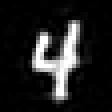

In [51]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = layers.InputLayer(shape = (None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

X_decoded = decode_encoded_input(X_encoded) * sigma + mu

X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print X_decoded.shape

### check it worked :

pic_array = get_picture_array(X_decoded, np.random.randint(len(X_decoded)))
image = Image.fromarray(pic_array)
image.save('data/test.png', format="PNG")  
IPImage('data/test.png')

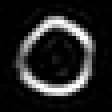

In [45]:
pic_array = get_picture_array(X_decoded, 39823)
image = Image.fromarray(pic_array)
IPImage('data/test.png')